In [236]:
import os
from pathlib import Path
import glob
from collections import defaultdict

from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
import xmltodict
from scipy.stats import pearsonr

import biolib as bl

In [3]:
DATA_DIR = Path("/Users/ricomeinl/Desktop/retro/biobank/")

In [4]:
def image_dict(directory):
    d = defaultdict(list)
    for f in glob.glob(os.path.join(directory, '*tiff')):
        base = os.path.basename(f)
        d[base.split('_')[2]].append(f)
    d = {k:sorted(l, key=lambda l: int(l.split('_')[3][1:])) for k,l in d.items()}
    return d

In [69]:
def concat(imgs):
    dst = Image.new('RGB', (sum([im.width for im in imgs[0]]), sum([im[0].height for im in imgs])))
    width = imgs[0][0].width
    height = imgs[0][0].height
    left_offset = 0
    top_offset = 0
    for i in range(6):
        for j in range(6):
            im = imgs[i][j]
            dst.paste(im, (j*width, i*height))
    return dst

In [72]:
imgs = []
rows = 6
tmp = []

for i,path in enumerate(d['a1']):
    im = Image.open(path)
    if (i != 0) and (i % rows == 0):
        imgs.append(tmp)
        tmp = []
    tmp.append(im)
imgs.append(tmp)

In [70]:
img = concat(imgs)

## analysis

In [115]:
def bin_age(age, max_age=110, step_size=10):
    bins = np.arange(0, max_age, step_size)
    labels = [f'{b}-{b+step_size}' for b in bins[:-1]]
    return pd.cut(age, bins=bins, labels=labels)

In [179]:
manual_df = pd.read_csv('data/manual_count.csv')
manual_df = manual_df.sort_values('donor_id', key=lambda k: k.str[1:].astype(int)).reset_index(drop=True)
manual_df['bin_age'] = bin_age(manual_df['age'])

In [180]:
d = {}
for fpath in [*DATA_DIR.glob("**/**/*xml")]:
    base = fpath.stem
    donors = fpath.parts[-3].split(' ')[0]
    if donors not in d:
        d[donors] = {}
    plate = base.split('_')[2]
    if plate not in d[donors]:
        d[donors][plate] = defaultdict(int)
    with open(fpath) as f:
        xml = f.read()
        objects = xmltodict.parse(xml)['annotation']['object']
        if not isinstance(objects, list):
            objects = [objects]
        for obj in objects:
            d[donors][plate][obj['name']] += 1
    # break

In [242]:
df = pd.DataFrame([(k, vk, vv['colony'], vv['big colony']) for k,v in d.items() for vk, vv in v.items()], columns=['donor_file', 'plate', 'colony', 'big colony'])

In [243]:
df['donor_id'] = df.apply(lambda row: row['donor_file'].split('-')[0].upper() if 'a' in row['plate'] else row['donor_file'].split('-')[1].upper(), axis=1)
df = df.sort_values('donor_id', key=lambda k: k.str[1:].astype(int))
df = df.merge(manual_df[['donor_id', 'age']], on='donor_id', how='right').drop_duplicates(subset=['donor_id', 'plate']).reset_index(drop=True).fillna(0.)
df['bin_age'] = bin_age(df['age'])

In [245]:
metrics.r2_score(df['age'], df['colony']), metrics.r2_score(df['age'], df['big colony'])

(-4.569322927492961, -6.123258187040571)

In [246]:
metrics.r2_score(manual_df['age'], manual_df['colony']), metrics.r2_score(manual_df['age'], manual_df['big colony'])

(-2.587598282415064, -4.525295935242406)

<AxesSubplot:xlabel='age', ylabel='colony'>

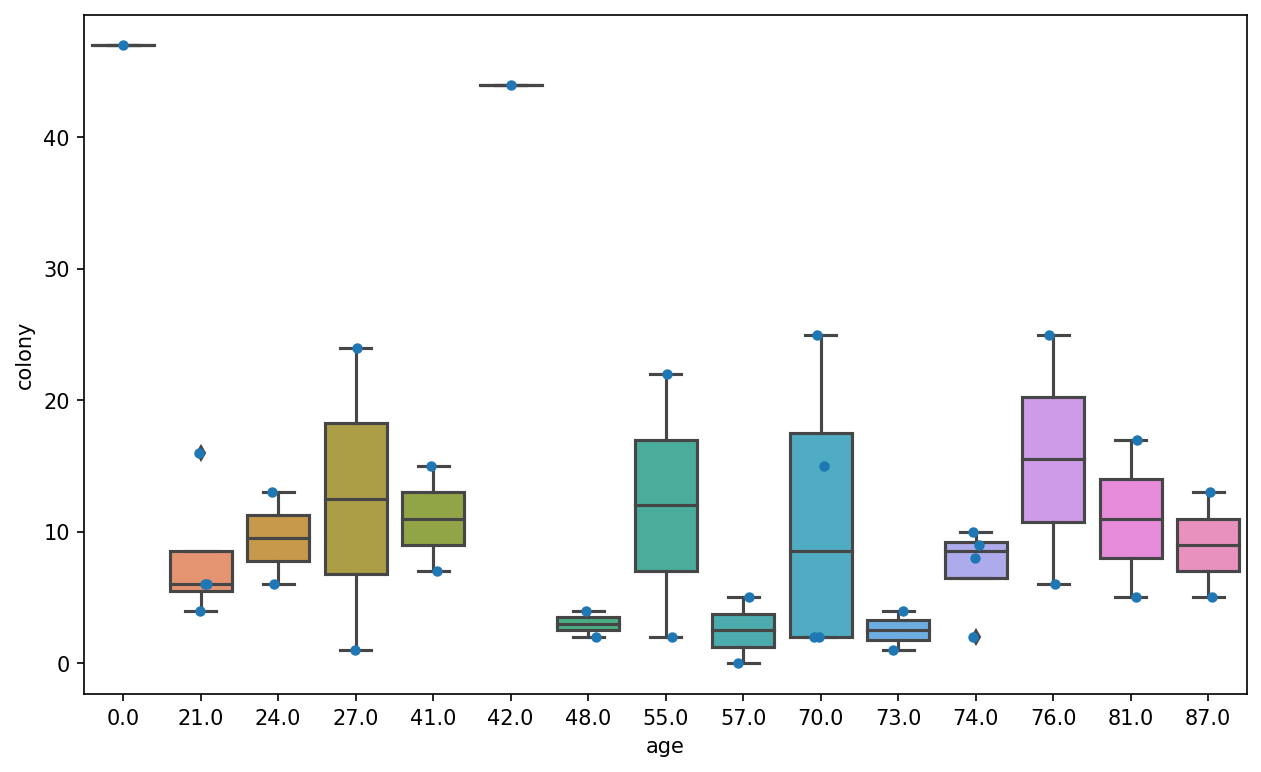

In [228]:
plt.figure(figsize=(10,6), dpi=150)
sns.boxplot(df, x='age', y='colony')
sns.stripplot(df, x='age', y='colony')

<AxesSubplot:xlabel='donor_id', ylabel='colony'>

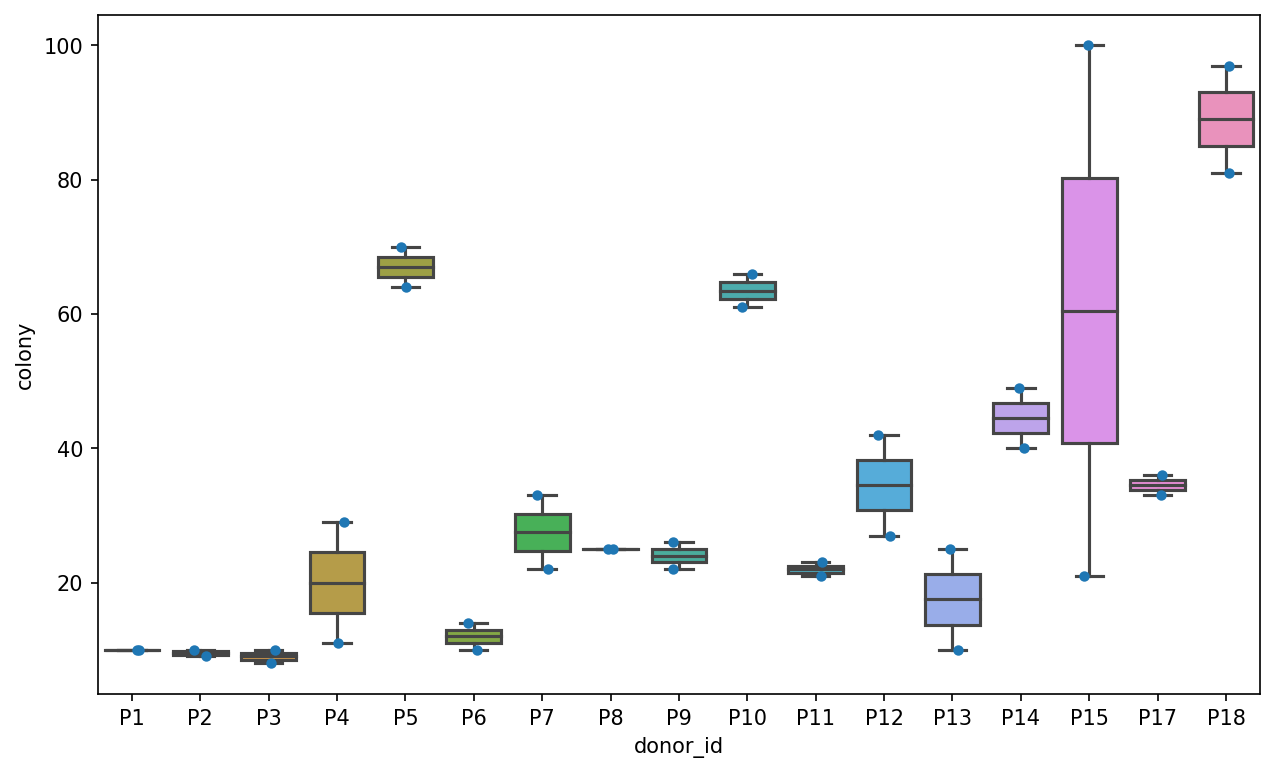

In [226]:
plt.figure(figsize=(10,6), dpi=150)
sns.boxplot(manual_df, x='donor_id', y='colony')
sns.stripplot(manual_df, x='donor_id', y='colony')

In [247]:
merged = df.merge(manual_df, on='donor_id').drop_duplicates(['plate', 'donor_id'])

Text(0.5, 1.0, 'r: 0.38')

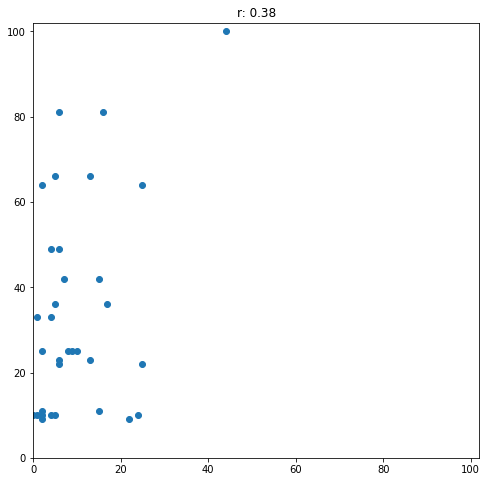

In [248]:
plt.figure(figsize=(8,8))
plt.scatter(merged['colony_x'], merged['colony_y'])
plt.xlim([0, max(merged['colony_x'].max(), merged['colony_y'].max())+2])
plt.ylim([0, max(merged['colony_x'].max(), merged['colony_y'].max())+2])
# plt.title(f"r^2: {metrics.r2_score(merged['colony_x'], merged['colony_y']):.2f}")
plt.title(f"r: {pearsonr(merged['colony_x'], merged['colony_y'])[0]:.2f}")

Text(0.5, 1.0, 'r: -0.10')

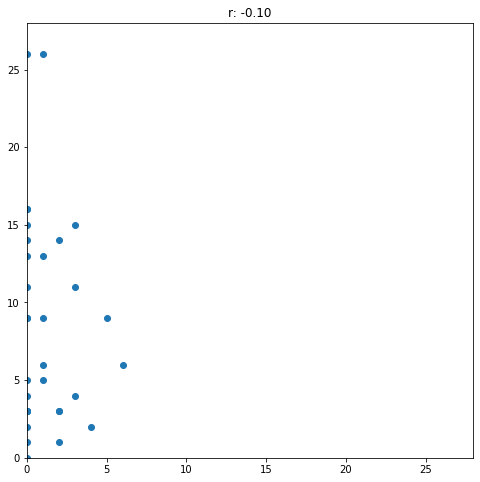

In [249]:
plt.figure(figsize=(8,8))
plt.scatter(merged['big colony_x'], merged['big colony_y'])
plt.xlim([0, max(merged['big colony_x'].max(), merged['big colony_y'].max())+2])
plt.ylim([0, max(merged['big colony_x'].max(), merged['big colony_y'].max())+2])
# plt.title(f"r^2: {metrics.r2_score(merged['big colony_x'], merged['big colony_y']):.2f}")
plt.title(f"r: {pearsonr(merged['big colony_x'], merged['big colony_y'])[0]:.2f}")

44